In [128]:
!pip install adjustText

In [129]:
from typing import Callable
from functools import partial
import scipy
print(scipy.__version__)

import numpy as np
import pandas as pd
import scipy.odr as odr
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib as mpl
import uncertainties
import matplotlib.cm as cm
from scipy.odr import ODR, Model, RealData
from scipy.optimize import brentq, minimize_scalar
from scipy.special import jn_zeros, spherical_jn
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from adjustText import adjust_text


1.13.1


In [130]:
# Constantes universales
hbar = 6.582119569e-16 # eV * s
c = 299792458 # m/s
m_e = 510.998e3 / c**2 # eV / c^2
q_e = 1.60217662e-19 # C
epsilon0 = 8.854187817e-12 # F/m
FWHM_FACTOR = 2 * np.sqrt(2 * np.log(2))

In [131]:
import matplotlib as mpl
import locale

mpl.rcParams.update({
    # --- FIGURA ---
    "figure.figsize": (8, 6),
    "figure.dpi": 120,

    # --- FUENTES Y TEXTO ---
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 16,
    "text.latex.preamble": r"""
        \usepackage[utf8]{inputenc}
        \usepackage[T1]{fontenc}
        \usepackage{lmodern}
        \usepackage{amsmath}     % ✅ necesario para \dfrac
        \usepackage{nicefrac}
        \usepackage[spanish, es-tabla]{babel}
        \AtBeginDocument{%
          \mathcode`,="013B % coma decimal sin espacio en modo matemático
        }"""
	,
    # --- ETIQUETAS Y TÍTULOS ---
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "axes.edgecolor": "gray",
    "axes.linewidth": 1.2,
    'axes.formatter.use_locale': False,

    # --- TICKS ---
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 6,
    "ytick.major.size": 6,

    # --- LEYENDAS ---
    "legend.fontsize": 14,
    "legend.edgecolor": "gray",
    "legend.facecolor": "lightyellow",
    "legend.framealpha": 1.0,
    "legend.loc": "best",

    # --- GRILLA ---
    "grid.linestyle": ":",
    "grid.alpha": 0.6,
    "grid.color": "gray",

    # --- GUARDADO ---
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.1,
    "savefig.format": "pdf",
    "savefig.dpi": 300,
    "savefig.transparent": True,
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white",
})

locale.setlocale(locale.LC_NUMERIC, 'es_ES.UTF-8')  # o 'es_AR.UTF-8'


'es_ES.UTF-8'

In [132]:
def npar_nom(a):
  return np.asarray([v.n for v in a])

def npar_std(a):
  return np.asarray([v.s for v in a])

def swap_ev_and_nm(v: float) -> float:
    # Convert an energy in eV to a wavelength in nm, and vice-versa
    return 1240 / v
def cot(x:float) -> float:
  return 1/np.tan(x)

def negative_to_nan(v: float | np.ndarray) -> float | np.ndarray:
    '''
    Turn negative values to np.nan.

    Implementing it this way significantly speeds up the numeric methods
    vs vectorizing a single function.
    '''
    if isinstance(v, float):
        return np.nan if v < 0 else v
    elif isinstance(v, np.ndarray):
        arr = v.copy()
        arr[arr < 0] = np.nan
        return arr

# Nueva sección

In [133]:
def calculate_absorbance(I_0, I_cristal):
  A_cristal = np.log10(np.abs(I_0 / I_cristal))
  return A_cristal

def load_data_series(url: str, series: list[str]) -> pd.DataFrame: # str define que el tipo de variable que es url es una cadena de caracteres
  df = pd.read_csv(url, sep='\t', header=0)
  df['Wavelength unc'] = [0.001 for i in df['Wavelength']] #df['nombre'] crea una nueva columna en el df cuyo encabezado es 'nombre'

  samples = [c[2:-1] for c in df.columns if c[:2] == 'I(' and c[-1] == ')' and c[-2]!='0']  # extrae lo que está dentro de "I(...)" en los nombres de columnas
  for n in series:
    for sample in samples:
      df[f'A({sample})'] = calculate_absorbance(df['I(0)_'+n], df[f'I({sample})'])
      df[f'A({sample}) unc'] = 0.01 * np.abs(df[f'A({sample})'])
      df[f'A({sample}) w/unc'] = [uncertainties.ufloat(df[f'A({sample})'][i], df[f'A({sample}) unc'][i]) for i in range(len(df[f'A({sample})']))]

  return df

def gaussiana(beta, x):
    # beta = [A, mu, sigma, offset]
    A, mu, s, offset = beta
    g = A * np.exp(- (x - mu)**2 / (2 * s**2)) + offset
    return g

def ajuste_ODR(x, y, errx, erry, beta0, func):
  model = Model(func)
  data = RealData(x, y, sx = errx, sy = erry)
  odr = ODR(data, model, beta0=beta0)
  out = odr.run()
  return out

In [134]:
url='https://docs.google.com/spreadsheets/d/e/2PACX-1vRmjMCSjahcxzRTIA3FH_0tB0TVugav5FNDmLOj_4FWUr4RGvniQCFPVGpUXbqrMy68pibhuv9dtIE4/pub?gid=1561431546&single=true&output=tsv'

df = load_data_series(url, ['1','2'])
df

,Wavelength,I(0)_1,I(NaCl),I(KCl),I(0)_2,I(KBr),I(KI),Wavelength unc,A(NaCl),A(NaCl) unc,A(NaCl) w/unc,A(KCl),A(KCl) unc,A(KCl) w/unc,A(KBr),A(KBr) unc,A(KBr) w/unc,A(KI),A(KI) unc,A(KI) w/unc
0,188.6370,-4.0278,-4.6241,-3.1815,-5.13,-1.3178,-8.0733,0.001,0.045090,0.000451,0.0451+/-0.0005,0.207485,0.002075,0.2075+/-0.0021,0.590268,0.005903,0.590+/-0.006,-0.196934,0.001969,-0.1969+/-0.0020
1,189.1073,-4.0278,-4.6241,-3.1815,-5.13,-1.3178,-8.0733,0.001,0.045090,0.000451,0.0451+/-0.0005,0.207485,0.002075,0.2075+/-0.0021,0.590268,0.005903,0.590+/-0.006,-0.196934,0.001969,-0.1969+/-0.0020
2,189.5776,-4.0278,-4.6241,-3.1815,-5.13,-1.3178,-8.0733,0.001,0.045090,0.000451,0.0451+/-0.0005,0.207485,0.002075,0.2075+/-0.0021,0.590268,0.005903,0.590+/-0.006,-0.196934,0.001969,-0.1969+/-0.0020
3,190.0478,-2.2278,-0.2574,-3.1815,-5.29,-0.5578,-3.2933,0.001,1.312847,0.013128,1.313+/-0.013,0.220824,0.002208,0.2208+/-0.0022,0.976977,0.009770,0.977+/-0.010,0.205824,0.002058,0.2058+/-0.0021
4,190.5180,-5.3944,-2.9907,0.5519,-5.73,-5.9978,-2.0333,0.001,0.282382,0.002824,0.2824+/-0.0028,1.016294,0.010163,1.016+/-0.010,-0.019837,0.000198,-0.01984+/-0.00020,0.449953,0.004500,0.450+/-0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,1099.1448,0.8722,-3.9907,-1.4481,3.31,-2.0578,-4.3333,0.001,-0.081221,0.000812,-0.0812+/-0.0008,0.359029,0.003590,0.359+/-0.004,0.206425,0.002064,0.2064+/-0.0021,-0.116991,0.001170,-0.1170+/-0.0012
2038,1099.5647,3.5056,-2.5574,-3.4481,3.93,-5.7578,-3.9933,0.001,0.186594,0.001866,0.1866+/-0.0019,0.056813,0.000568,0.0568+/-0.0006,-0.165864,0.001659,-0.1659+/-0.0017,-0.006939,0.000069,-0.00694+/-0.00007
2039,1099.9847,2.7722,6.2759,-4.5148,10.27,12.5422,8.4467,0.001,0.213894,0.002139,0.2139+/-0.0021,0.356932,0.003569,0.357+/-0.004,-0.086803,0.000868,-0.0868+/-0.0009,0.084883,0.000849,0.0849+/-0.0008
2040,1100.4046,3.2056,0.9093,-1.9481,3.81,3.4222,3.7067,0.001,0.622218,0.006222,0.622+/-0.006,0.291314,0.002913,0.2913+/-0.0029,0.046620,0.000466,0.0466+/-0.0005,0.011938,0.000119,0.01194+/-0.00012


In [135]:
class CrystalSpectra:
    def __init__(self, url : str, series:list[str], ranges_dict: dict[str, tuple[int, int]], beta0_dict: dict[str, list[float]]):
        self.url = url
        self.series = series
        self.dataframe = load_data_series(url, series)
        self.ranges = ranges_dict
        self.beta0 = beta0_dict   # parámetros iniciales de ajuste
        self.fit_results = {}     # acá vamos a guardar los parámetros de los ajustes

    def plot_absorbance_spectrums(self):
          absorbance_cols = [c for c in df.columns if c.startswith("A(") and "unc" not in c]
          for sample in absorbance_cols:
              mask = (df['Wavelength']>400) & (df['Wavelength']<900)
              x=df['Wavelength'][mask]
              y=df[sample][mask]/max(df[sample][mask])
			# Desplazar los valores para que sean todos positivos
              plt.plot(
                  x,
                  y,
                  lw=1,
                  label=f"{sample[2:-1]}"
              )
          plt.xlabel('Longitud de onda (nm)')
          plt.ylabel('Absorbancia normalizada [u.a]')
          plt.legend()
          plt.show()

    def fit_peaks(self, plot: bool = True):
        for  name in  self.ranges.keys():
            x_min, x_max = self.ranges[name]
            beta0 = self.beta0[name]

            x = df['Wavelength']
            y = df[f'A({name})']
            errx = df['Wavelength unc']
            erry = df[f'A({name}) unc']

            mask = (x >= x_min) & (x <= x_max)
            x, y, errx, erry = x[mask], y[mask], errx[mask], erry[mask]

            # guardo el resultado del ajuste ODR en fit_result
            self.fit_results[name] = ajuste_ODR(x, y, errx, erry, beta0, gaussiana)
			

            # gráficos solo si plot=True
            if plot:
                plt.figure()
                plt.errorbar(x, y, xerr=errx, yerr=erry, fmt='.', label=name, c='blue')
                plt.plot(x, gaussiana(self.fit_results[name].beta, x), 'r-', lw=2, label='Ajuste gaussiana', zorder=100)
                plt.vlines(self.fit_results[name].beta[1], ymin=min(y), ymax=max(y), color='black', linestyle='--', label=r'$\lambda_\mathrm{máx}$')
                plt.xlabel("Longitud de onda (nm)")
                plt.ylabel("Absorbancia")
                plt.legend()
                plt.grid()
                plt.show()

    def _ensure_fitted(self):
      #método interno para asegurar que el ajuste ya se haya ejecutado.
      if not self.fit_results:
          self.fit_peaks(plot=False)
    @property
    def A(self):
      self._ensure_fitted() # verifica si se ejecutó el ajuste
      dic = {}
      for name in self.ranges.keys():
          if name in self.fit_results and self.fit_results[name] is not None:
              dic[name] = uncertainties.ufloat(self.fit_results[name].beta[0], self.fit_results[name].sd_beta[0])
          else:
              dic[name] = np.nan
      return dic

    @property
    def mu(self):
      self._ensure_fitted() # verifica si se ejecutó el ajuste
      dic = {}
      for name in self.ranges.keys():
          if name in self.fit_results and self.fit_results[name] is not None:
              dic[name] = uncertainties.ufloat(self.fit_results[name].beta[1], self.fit_results[name].sd_beta[1])
          else:
              dic[name] = np.nan
      return dic

    @property
    def sigma(self):
      self._ensure_fitted() # verifica si se ejecutó el ajuste
      dic = {}
      for name in self.ranges.keys():
          if name in self.fit_results and self.fit_results[name] is not None:
              dic[name] = uncertainties.ufloat(self.fit_results[name].beta[2], self.fit_results[name].sd_beta[2])
          else:
              dic[name] = np.nan
      return dic

    @property
    def y_0(self):
      self._ensure_fitted() # verifica si se ejecutó el ajuste
      dic = {}
      for name in self.ranges.keys():
          if name in self.fit_results and self.fit_results[name] is not None:
              dic[name] = uncertainties.ufloat(self.fit_results[name].beta[3], self.fit_results[name].sd_beta[3])
          else:
              dic[name] = np.nan
      return dic

    def get_fit_params_df(self) -> pd.DataFrame:

      self._ensure_fitted() # verifica si se ejecutó el ajuste
      df = pd.DataFrame({
          'A': self.A,
          'mu': self.mu,
          'sigma': self.sigma,
          'y_0': self.y_0
      })

      return df

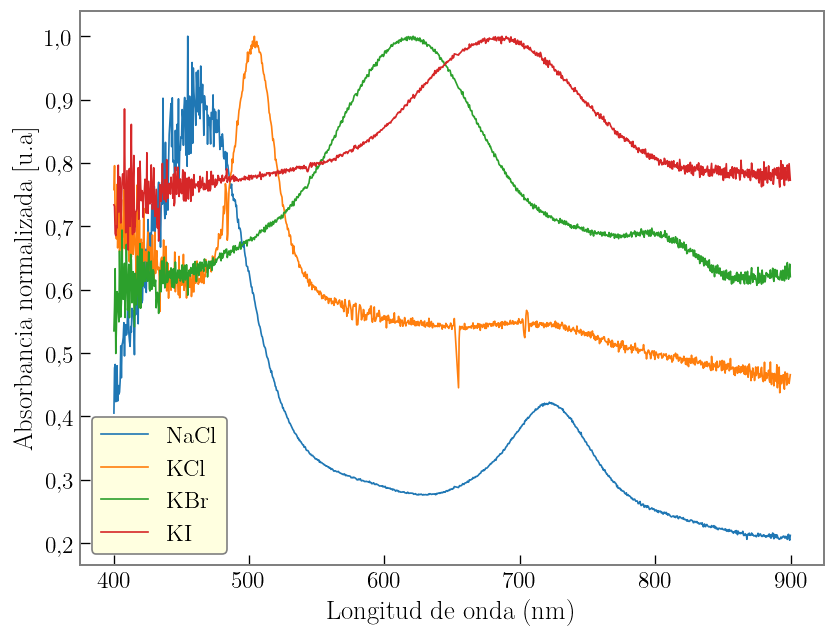

In [136]:
#en este url están todos los datos "experimentales" correspondientes a las 2 series
url='https://docs.google.com/spreadsheets/d/e/2PACX-1vRmjMCSjahcxzRTIA3FH_0tB0TVugav5FNDmLOj_4FWUr4RGvniQCFPVGpUXbqrMy68pibhuv9dtIE4/pub?gid=1561431546&single=true&output=tsv'

ranges = {
    'NaCl': (350, 570),
    'KCl': (470, 540),
    'KBr': (500, 750),
    'KI':  (550, 820)
}

beta0 = {
    'NaCl': [1.6, 460, 20, 0.5],
    'KCl':  [0.65, 510, 10, 0.5],
    'KBr':  [0.75, 620, 20, 0.5],
    'KI':   [0.9, 690, 10, 0.5]
}


#como están las dos series, recorremos ['1','2']

crystal_spectra = CrystalSpectra(url,['1','2'], ranges, beta0)

crystal_spectra.plot_absorbance_spectrums()

#crystal_spectra.plot_absorbance_spectrums()
#crystal_spectra.fit_peaks(plot=True)

#tenemos un df con los resultados de los ajustes.
df_res = crystal_spectra.get_fit_params_df()

#le agregamos el valor de la constante de red correspondiente a cada cristal
df_res['a'] = [0.564 , 0.6294, 0.6596, 0.7066]

# Accede a la propiedad
mu_values = crystal_spectra.mu

# El objeto devuelto es un diccionario con los valores de mu para cada muestra
#print(mu_values)




In [137]:
df_res


,A,mu,sigma,y_0,a
NaCl,1.091+/-0.010,461.47+/-0.27,38.0+/-0.4,0.494+/-0.005,0.5640
KCl,0.2541+/-0.0021,504.12+/-0.08,13.51+/-0.16,0.4316+/-0.0020,0.6294
KBr,0.2369+/-0.0006,619.16+/-0.09,47.21+/-0.17,0.5043+/-0.0005,0.6596
KI,0.2006+/-0.0005,683.20+/-0.07,58.54+/-0.18,0.7133+/-0.0005,0.7066


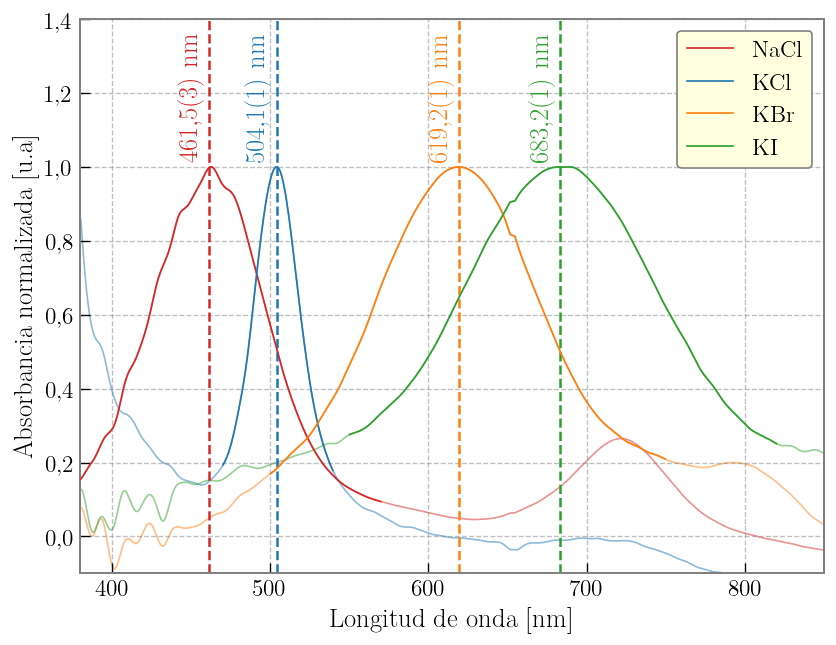

In [138]:
url='https://docs.google.com/spreadsheets/d/e/2PACX-1vRmjMCSjahcxzRTIA3FH_0tB0TVugav5FNDmLOj_4FWUr4RGvniQCFPVGpUXbqrMy68pibhuv9dtIE4/pub?gid=1561431546&single=true&output=tsv'

df = load_data_series(url, ['1','2'])

#aplicar un filtro pasa bajas a la absorbancia para eliminar ruido de alta frecuencia de cada espectro
from scipy.signal import butter, filtfilt
def butter_lowpass(cutoff, fs, order=5):
	nyq = 0.5 * fs
	normal_cutoff = cutoff / nyq
	b, a = butter(order, normal_cutoff, btype='low', analog=False)
	return b, a
def lowpass_filter(data, cutoff, fs, order=5):
	b, a = butter_lowpass(cutoff, fs, order=order)
	y = filtfilt(b, a, data)
	return y
# Parámetros del filtro
cutoff = 0.1  # Frecuencia de corte en Hz
fs = 3.0      # Frecuencia de muestreo en Hz
order = 3     # Orden del filtro

# Aplicar el filtro a cada espectro de absorbancia
absorbance_cols = [c for c in df.columns if c.startswith("A(") and "unc" not in c]
for sample in absorbance_cols:
    df[sample+'_filtered'] = lowpass_filter(df[sample], cutoff, fs, order)
# Ahora los datos filtrados están en las nuevas columnas con el sufijo '_filtered'
df.head()
# Graficar los espectros filtrados y normalizados, aplicando una normalización y un desplazamiento vertical dado por el correspondiente y_0 del fit para mejor visualización
absorbance_cols_filtered = [c for c in df.columns if c.startswith("A(") and c.endswith("_filtered")]
colors = [
     "#d62728","#1f77b4", "#ff7f0e", "#2ca02c"
]
fig= plt.figure()
for sample in absorbance_cols_filtered:
	sample_name = sample[2:-10]  # Extraer el nombre de la muestra sin 'A(' y '_filtered'
	y_0 = df_res.loc[sample_name, 'y_0']  # Obtener el valor de y_0 del fit
	y = df[sample] - y_0.n+0.05  # Restar y_0 para desplazar verticalmente
	mask = (df['Wavelength']>380) & (df['Wavelength']<950)
	y = y[mask]
	y_normalized = y / np.max(y) # Normalizar
	x = df['Wavelength'][mask]
	# Graficar el espectro intenso en la región de cada pico y con una linea clara fuera del pico, usando los ranges definidos anteriormente
	x_min = ranges[sample_name][0]
	x_max = ranges[sample_name][1]
	mask_peak = (x >= x_min) & (x <= x_max)
	# Graficar el espectro intenso en la región de cada pico
	plt.plot(x[mask_peak], y_normalized[mask_peak], lw=1, label=f"{sample_name}", color=colors[list(absorbance_cols_filtered).index(sample)], zorder=10)
	
	plt.plot(x, y_normalized, lw=1, color=colors[list(absorbance_cols_filtered).index(sample)], alpha=0.5, zorder=1)
	
	'''
	plt.plot(
		x,
		y_normalized,
		lw=1,
		label=f"{sample_name}"
		,color=colors[list(absorbance_cols_filtered).index(sample)])
	'''
	plt.vlines(df_res.loc[sample_name, 'mu'].n, ymin=-0.1, ymax=1.4, colors=colors[list(absorbance_cols_filtered).index(sample)], linestyles='--')
	#añadir una etiqueta con el valor de la longitud de onda máxima al lado de cada línea punteada en vertical
	#, label=r"$\lambda_\mathrm{máx}$"+ 
	plt.text(df_res.loc[sample_name, 'mu'].n - 20, 1.03, f"${df_res.loc[sample_name, 'mu'].n:.1f}({df_res.loc[sample_name, 'mu'].s*10:.0f})$ nm", color=colors[list(absorbance_cols_filtered).index(sample)] 
         , rotation=90 )
plt.ylim(-0.1, 1.4)
plt.xlim(380, 850)
plt.xlabel('Longitud de onda [nm]')
plt.ylabel('Absorbancia normalizada [u.a]')
plt.legend(loc='upper right')
plt.grid(linestyle='--', alpha=0.5)
plt.savefig('Absorbancia_filtrada_normalizada')
plt.show()

In [169]:
# Load the literature references
url_ref = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRmjMCSjahcxzRTIA3FH_0tB0TVugav5FNDmLOj_4FWUr4RGvniQCFPVGpUXbqrMy68pibhuv9dtIE4/pub?gid=75805461&single=true&output=tsv'
all_crystals = pd.read_csv(url_ref, sep='\t', header=0, index_col=0, engine='python') # Use explicit tab separator and python engine
all_crystals['a inc. [nm]'] = 0.0001 # Fixed 0.0001 nm uncertainty for all lattice constants
# Select and reorder columns using the correct column names
all_crystals = all_crystals[['a [nm]', 'a inc. [nm]', 'E Literatura [eV]']]


# Initialize the measured energies (to maintain the "correct" order)
all_crystals['E Medida [eV]'] = float('nan')
all_crystals['E Medida inc. [eV]'] = float('nan')

# Initialize combined energies
all_crystals['E [eV]'] = all_crystals['E Literatura [eV]']
all_crystals['E inc. [eV]'] = 0.001 * all_crystals['E [eV]']


# Add the measured spectrum peaks only to those rows corresponding to crystals that were measured
for name, mu in mu_values.items():

    all_crystals.loc[name, 'E Medida [eV]'] = swap_ev_and_nm(mu).n
    all_crystals.loc[name, 'E Medida inc. [eV]'] = swap_ev_and_nm(mu).s

    all_crystals.loc[name, 'E [eV]'] = all_crystals.loc[name, 'E Medida [eV]']
    all_crystals.loc[name, 'E inc. [eV]'] = all_crystals.loc[name, 'E Medida inc. [eV]']

all_crystals


,a [nm],a inc. [nm],E Literatura [eV],E Medida [eV],E Medida inc. [eV],E [eV],E inc. [eV]
Sample,,,,,,,
LiI,0.6000,0.0001,3.176,NaN,NaN,3.176000,0.003176
LiF,0.4028,0.0001,5.083,NaN,NaN,5.083000,0.005083
LiCl,0.5140,0.0001,3.256,NaN,NaN,3.256000,0.003256
LiBr,0.5502,0.0001,2.767,NaN,NaN,2.767000,0.002767
NaF,0.4634,0.0001,3.702,NaN,NaN,3.702000,0.003702
NaCl,0.5640,0.0001,2.746,2.687076,0.001597,2.687076,0.001597
NaBr,0.5978,0.0001,2.345,NaN,NaN,2.345000,0.002345
NaI,0.6474,0.0001,2.063,NaN,NaN,2.063000,0.002063
KF,0.5348,0.0001,2.873,NaN,NaN,2.873000,0.002873


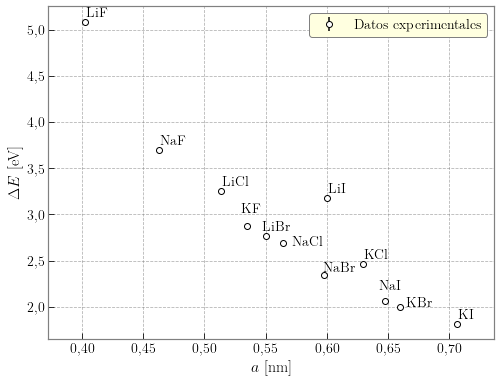

In [140]:
def plot_all(solutions: dict[str, Callable[[float], float] | dict[float, float]] | None = None,
             legend_outside: bool = False,
             y_range: tuple[float, float] | None = None,
             save: str | None = None):
    # Get x-axis range
    x_range = max(all_crystals['a [nm]']) - min(all_crystals['a [nm]'])

    labels = []
    for crystal in all_crystals.index:
        labels.append(plt.text(all_crystals.loc[crystal, 'a [nm]'], all_crystals.loc[crystal, 'E [eV]'], crystal,verticalalignment='bottom' ,horizontalalignment='left', rotation=0
                               ,zorder=1000 , fontsize=14, alpha = 1) )

    # Plot the energies
    plt.errorbar(all_crystals['a [nm]'], all_crystals['E [eV]'], yerr=all_crystals['E inc. [eV]'], marker='o', linestyle='None', markerfacecolor='white',color='black', zorder=200, label='Datos experimentales')
    x_values = np.linspace(all_crystals['a [nm]'].min(), all_crystals['a [nm]'].max(), 1000)
    if solutions is not None:
        for name, sol in solutions.items():
            if isinstance(sol, dict):
                xs = list(sol.keys())
                ys = list(sol.values())

                if isinstance(ys[0], uncertainties.UFloat):
                    ys_err = [v.std_dev for v in ys]
                    ys = [v.n for v in ys]
                    plotline, _, _ = plt.errorbar(xs, ys, yerr=ys_err, marker='s', label=name, linestyle='None', zorder=100)
                    plotline.set_markerfacecolor('none')
                else:
                    plt.plot(xs, ys, marker='s', markerfacecolor='none', label=name, linestyle='None', zorder=100 )
            else:
                plt.plot(x_values, sol(x_values), label=name, zorder=100)

    if solutions:
        if legend_outside:
            plt.legend(loc='upper left')
        else:
            plt.legend(loc='upper right')

    plt.xlabel(r'$a$ [nm]')
    plt.ylabel(r'$\Delta E$ [eV]')
    plt.tick_params(axis='both')
    if legend_outside:
      plt.legend( loc='upper right')
    else:
      plt.legend( loc='upper right')

    plt.grid(True, linestyle='--')
    if y_range is not None:
        plt.ylim(y_range)
    plt.xlim(min(all_crystals['a [nm]']) - 0.1 * x_range, max(all_crystals['a [nm]']) + 0.1 * x_range)

    adjust_text(labels, expand=(1, 1.1))

    if save:
        plt.savefig(save)

plot_all()

Fit stop: ['Sum of squares convergence']
Fit parameters: C = 0.9564580604390636 ± 0.05927088053938203, n = 1.8543380076378122 ± 0.13242383282157194


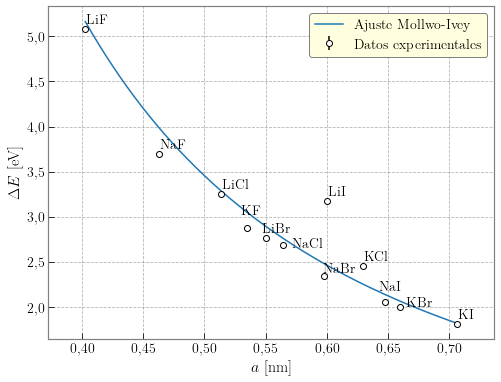

In [141]:
# Fit de Mollwo-Ivey relation
def mollwo_ivey(B: list[float], x: float) -> float:
    return B[0] * x**(-B[1])
mollwo_ivey_model = odr.Model(mollwo_ivey)

mask = all_crystals.index != 'LiI'
data = odr.RealData(
    all_crystals['a [nm]'][mask],
    all_crystals['E [eV]'][mask],
    sx=all_crystals['a inc. [nm]'][mask],
    sy=all_crystals['E inc. [eV]'][mask],
)
fit = odr.ODR(data, mollwo_ivey_model, beta0=[1, 1])
fit_result = fit.run()
print(f'Fit stop: {fit_result.stopreason}')
print(f'Fit parameters: C = {fit_result.beta[0]} ± {fit_result.sd_beta[0]}, n = {fit_result.beta[1]} ± {fit_result.sd_beta[1]}')

mollvo_ivey_solution = partial(mollwo_ivey, fit_result.beta)
mi_solutions = {'Ajuste Mollwo-Ivey': mollvo_ivey_solution}
plot_all(solutions=mi_solutions, save = 'mollwo_ivey_plot')

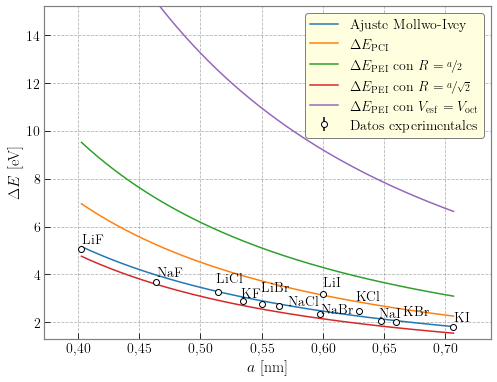

In [142]:
def sphere_radius(a: float , tipo : str) -> float:
    L = a/np.sqrt(2)
    if tipo == 'volumen':
        return L * (np.cbrt(np.sqrt(2) / (4 * np.pi)))
    elif tipo == 'inscrita':
        return a / (np.sqrt(2))
    elif tipo == 'circunscrita':
        return a / 2

def pozo_cubico_inf(a: float) -> float:
  """
  Calcula la energía de la transición cuántica del estado (1,1,1) al (2,1,1)
  para un electrón en un pozo de potencial cúbico.
  El cubo se toma de lados igual a la constante de red a
  """
  # a en nm
  L = a * 1e-9
  delta_E = 3 * (hbar*np.pi)**2 / (2 * m_e * L**2)
  return delta_E

def pozo_esferico_inf(r: float) -> float:
    """
    Calcula la energía de la transición cuántica del estado (1,0) al (1,1)
    para un electrón en un pozo de potencial esférico.
    El radio de la esfera puede modificarse previamente mediante la función sphere_radius
    """
    # r en nm
    x_10 = np.pi
    x_11 = jn_zeros(1, 1)[0]
    #diferencia_cuadrados_x = x_11**2 - x_10**2
    diferencia_cuadrados_x =10.135
    R = r * 1e-9
    delta_E = (hbar**2 * diferencia_cuadrados_x) / (2 * m_e * R**2)

    return delta_E




infinite_solutions = {
    r'$\Delta E_\mathrm{PCI}$': pozo_cubico_inf,
    r'$\Delta E_\mathrm{PEI}$ con $R=\nicefrac{a}{2}$': lambda a: pozo_esferico_inf(sphere_radius(a, 'circunscrita')),
    r'$\Delta E_\mathrm{PEI}$ con $R=\nicefrac{a}{\sqrt{2}}$': lambda a: pozo_esferico_inf(sphere_radius(a, 'inscrita')),
    r'$\Delta E_\mathrm{PEI}$ con $V_{\mathrm{esf}}=V_\mathrm{oct}$': lambda a: pozo_esferico_inf(sphere_radius(a, 'volumen')),
}

plot_all(solutions=mi_solutions | infinite_solutions, y_range=[1.3,15.2], save = 'modelos y ajuste.pdf')

# Pozo esférico finito


Las soluciones (y sus derivadas) correspondientes a los autoestados ligados del pozo esférico finito tridimensional deben ser continuas en el borde del potencial radial ($r=a$), satisfaciendo:

\begin{equation}
A_{l} j_{l}(ka) = B_{l} h^{(1)}_{l}(i \kappa a), 
\qquad
A_{l} k j'_{l}(ka) = i B_{l} \kappa h^{(1)'}_{l}(i \kappa a),
\end{equation}

donde

\begin{equation}
E = - \frac{\hbar^{2}}{2m}\kappa^{2}, 
\qquad 
E + V_{0} = \frac{\hbar^{2}}{2m}k^{2}.
\end{equation}

Podemos unificar estas dos expresiones como

\begin{equation}
(ka)^{2} + (\kappa a)^{2} = \xi^{2} + \eta^{2} = \frac{2m V_{0} a^{2}}{\hbar^{2}} = r_{0}^{2},
\end{equation}

con

\begin{equation}
\xi = ka, 
\qquad 
\eta = \kappa a.
\end{equation}

Las condiciones de contorno pueden reescribirse como

\begin{equation}
\frac{ka \, j'_{l}(ka)}{j_{l}(ka)} = i \kappa a \, \frac{h^{(1)'}_{l}(i \kappa a)}{h^{(1)}_{l}(i \kappa a)}.
\end{equation}

Queremos calcular las energías de los estados $l=0$ y $l=1$, involucrados en la transición del estado fundamental al primer estado excitado que queremos modelar para el electrón atrapado en la vacante de red.

## Nivel fundamental ($l = 0$)

En este caso,

\begin{equation}
j_{0}(x) = \frac{\sin x}{x}, 
\qquad 
h^{(1)}_{0}(x) = j_{0}(x) + i y_{0}(x) = \frac{\sin x}{x} - i \frac{\cos x}{x}.
\end{equation}

En conjunto, la solución toma la forma simplificada

\begin{equation}
\eta = -\frac{\xi}{\tan \xi},
\end{equation}

donde $\eta$ y $\xi$ deben ser también soluciones de

\begin{equation}
\xi^{2} + \eta^{2} = r_{0}^{2}.
\end{equation}


 ## Primer nivel excitado ($l = 1$)


En este caso,

\begin{equation}
j_{1}(x) = \frac{\sin x}{x^{2}} - \frac{\cos x}{x},
\qquad 
h^{(1)}_{1}(x) = j_{1}(x) + i y_{1}(x) 
= \frac{\sin x}{x^{2}} - \frac{\cos x}{x} 
- i \left( \frac{\cos x}{x^{2}} + \frac{\sin x}{x} \right).
\end{equation}

Aplicando las condiciones de contorno, se llega a una relación implícita entre $\eta$ y $\xi$, dada por

\begin{equation}
\eta^{2} \, \xi \cos \xi = \left( \xi^{2}(1+\eta) + \eta^{2} \right) \sin \xi.
\end{equation}

In [143]:
def get_r0(v0, a):
    '''
    @param v0: in eV
    @param r: in nm
    '''
    r = sphere_radius(a, 'circunscrita')*1e-9
    return np.sqrt(2 * m_e * v0) * r / hbar

def fn_root(xi: float, r0: float) -> float:
    return np.sqrt(r0**2 - xi**2)

def negative_to_nan(v: float | np.ndarray) -> float | np.ndarray:
    '''
    Turn negative values to np.nan.

    Implementing it this way significantly speeds up the numeric methods
    vs vectorizing a single function.
    '''
    if isinstance(v, float):
        return np.nan if v < 0 else v
    elif isinstance(v, np.ndarray):
        arr = v.copy()
        arr[arr < 0] = np.nan
        return arr

    raise TypeError('Input must be a float or a numpy array')

def fn_sol_l0(xi: float) -> float:
    return negative_to_nan(-xi/np.tan(xi))

def fn_sol_l1_single(xi: float):
    def implicit_solution_l1(eta: float, xi: float):
        return eta**2 * xi * np.cos(xi) - (xi**2 * (1 + eta) + eta**2) * np.sin(xi)
    return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
fn_sol_l1 = np.vectorize(fn_sol_l1_single)

def get_fsw_energy(xi: float, r: float, v0: float) -> float:
    '''Invert the xi definition'''
    return hbar**2 * xi**2 / (2 * m_e * (r)**2) - v0

In [144]:
def find_all_roots(f, x_min: float, x_max: float, step: float | None = None, n_steps: int | None = None) -> list[float]:
    '''
    Use a sliding window approach to find all roots of the function f in the interval [x_min, x_max].
    '''
    if step and n_steps:
        raise ValueError('Cannot specify both step and n_steps')
    if not step:
        if not n_steps: n_steps = 1000
        step = (x_max - x_min)/n_steps
    xs = np.arange(x_min, x_max, step)

    roots = []
    for x1, x2 in zip(xs[:-1], xs[1:]):
        y1, y2 = f(x1), f(x2)

        # Check if function crosses zero in [x1, x2]
        if y1 == 0:
            # Exact zero at grid point
            roots.append(x1)
        elif y2 == 0:
            # Exact zero at grid point
            roots.append(x2)
        elif y1 * y2 < 0:
            # There is a root within the open interval
            try:
                # We'll find it with brentq
                roots.append(opt.brentq(f, x1, x2))
            except ValueError:
                # No root despite sign change (rare, numerical issue)
                pass

    # Round roots to overcome limits in the numerical precision,
    # and remove duplicates
    return np.unique(np.round(roots, 12))

In [145]:
def get_fsw_transition_solutions(v0: float, a: float) -> tuple[list[float], list[float]]:
    '''
    Solve the finite spherical well equation numerically, and get the first and second bound states' xi values.

    @param v0: Depth of the well in eV.
    @param r: Radius of the well in nm.

    @return: A tuple with the xi values for the fundamental (with l=0) and the first excited level (with l=1).
    '''
    r = sphere_radius(a,'circunscrita')*1e-9
    r0 = get_r0(v0, a)

    # First, find the range in which we'll look for intersections between the curves.
    search_min = 1e-4 # Avoid the singularities at 0
    # The maximum number of bound states will be when r = r0, since we only want to cover the first levels.
    search_max = r0

    l0_zeros = find_all_roots(lambda xi: fn_sol_l0(xi) - fn_root(xi, r0), search_min, search_max)
    l1_zeros = find_all_roots(lambda xi: fn_sol_l1(xi) - fn_root(xi, r0), search_min, search_max)

    return l0_zeros, l1_zeros


def get_fsw_1st_transition_energy(v0: float, a: float) -> float:
    '''
    Solve the finite spherical well equation numerically, and get the energy of the
    fundamental (l=0) -> first excited level (l=1), if available.

    @param v0: Depth of the well in eV.
    @param r: Radius of the well in nm.

    @return: The energy of the first transition (if allowed) or NaN.
    '''
    r = sphere_radius(a,'circunscrita')*1e-9
    l0_zeros, l1_zeros = get_fsw_transition_solutions(v0, a)
    if len(l0_zeros) < 1 or len(l1_zeros) < 1:
        return np.nan

    return get_fsw_energy(l1_zeros[0], r, v0) - get_fsw_energy(l0_zeros[0], r, v0)


def plot_fsw_bound_states(v0: float = 20, a: float = 0.2, save: str | None = None):
    '''
    Solve the finite spherical well equation graphically, and get the first and second bound states' energy levels.

    @param v0: Depth of the well in eV.
    @param r: Radius of the well in nm.
    @param save: If specified, save the plot to this file.
    '''
    r = sphere_radius(a)*1e-9
    r0 = get_r0(v0, a)

    # X-axis values
    xi = np.linspace(1e-3, r0, 1000)

    # Clear the previous plot (in case we're using an interactive backend)
    #plt.cla()

    # Draw the function
    plt.plot(xi, fn_root(xi, r0), label=r'$\sqrt{r_0^2 - \xi^2}$')
    plt.plot(xi, fn_sol_l0(xi), label=r'$l=0$ solutions', linestyle='--')
    plt.plot(xi, fn_sol_l1(xi), label=r'$l=1$ solutions', linestyle='--')

    #plt.axvline(r0, linestyle=':', color='gray')
    plt.xlabel(r'$\xi$')
    plt.ylabel(r'$\eta$')
    y_max = r0
    plt.ylim(0, r0+2)

    plt.legend(loc='upper right')


    # Now solve the equation numerically
    l0_states, l1_states = get_fsw_transition_solutions(v0, a)

    labels = []
    def process_solutions(solutions: list[float], fn) -> tuple[list[float], list[float]]:
        x_lst = []
        y_lst = []
        for x in solutions:
            if x is np.nan: continue
            y = fn(x)
            if y > y_max: continue

            x_lst.append(x)
            y_lst.append(y)

            labels.append(plt.text(x, y, f'{get_fsw_energy(x, r, v0):.2f} eV', horizontalalignment='left'))

        return x_lst, y_lst

    plt.plot(*process_solutions(l0_states, fn_sol_l0), 'o', color='purple', linestyle='None')
    plt.plot(*process_solutions(l1_states, fn_sol_l1), 'o', color='purple', linestyle='None')

    adjust_text(labels, expand=(1.3, 1.3))

    if save:
        plt.savefig(save)

    plt.show()

In [146]:
def plot_all_crystal_bound_states(all_crystals: pd.DataFrame, v0: float = 6.0):
    '''
    Genera un gráfico que muestra las soluciones (raíces) para múltiples cristales.
    
    @param all_crystals: DataFrame con los parámetros de red 'a [nm]'.
    @param v0: Profundidad del pozo en eV (V0).
    '''
    
    # 1. Definir funciones Trascendentales Fijas (l=0, l=1)
    # Estas curvas son universales e independientes del cristal (solo dependen de xi)
    # Usaremos un rango amplio de xi para que todas las curvas trascendentales sean visibles
    xi_universal = np.linspace(1e-3, 10, 1000)

    # Calcular las curvas trascendentales
    # Nota: fn_sol_l1 necesita un argumento dummy r0, ya que es la única manera de que la función sepa qué r0 usar
    # Si fn_sol_l1 está definida como en el ejemplo anterior, no necesitamos r0.

    # 2. Inicializar el Gráfico
    plt.figure(figsize=(12, 8))
    plt.xlabel(r'$\xi$ ')
    plt.ylabel(r'$\eta$ ')
    plt.ylim(0, 8) # Límite superior para visualizar mejor
    plt.xlim(0, 6) # Límite en x

    # Graficar las curvas Trascendentales (las ramas de la solución)
    # Son las mismas para todos los cristales
    plt.plot(xi_universal, fn_sol_l0(xi_universal), label=r'Soluciones con $l=0$', color='gray', linestyle='--', lw=1.5)
    plt.plot(xi_universal, fn_sol_l1(xi_universal), label=r'Soluciones con $l=1$', color='black', linestyle=':', lw=1.5)

    
    # 3. Iterar sobre Cada Cristal (Cada curva de enlace)
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_crystals))) # Genera colores distintos

    for i, (name, row) in enumerate(all_crystals.iterrows()):
        a = row['a [nm]']
        r = sphere_radius(a, 'circunscrita') # Obtener el radio real
        r0 = get_r0(v0, a)             # Calcular r0 para este cristal
        
        # 3.1 Rango de xi para la curva de enlace (hasta r0)
        xi_crystal = np.linspace(1e-4, r0 - 1e-4, 500)
        
        # 3.2 Graficar la Curva de Enlace (el Círculo)
        # La curva de enlace es la que es diferente para cada cristal
        plt.plot(xi_crystal, fn_root(xi_crystal, r0), 
                 color=colors[i], 
                 label=f'{name} ($a={a:.3f}$ nm)')
        
        # 3.3 Encontrar y Señalar las Raíces para este cristal
        # Usamos tu función para encontrar las xi de los estados l=0 y l=1
        l0_zeros, l1_zeros = get_fsw_transition_solutions(v0, a)
        
        # Señalar las intersecciones (raíces) en el gráfico
        def plot_roots(zeros, fn_sol):
            for xi_root in zeros:
                eta_root = fn_root(xi_root, r0)
                # Opcional: Verificar que fn_sol(xi_root) es cercano a eta_root
                # Señalar el punto de intersección
                plt.plot(xi_root, eta_root, 'o', markersize=5, color=colors[i], markeredgecolor='k')
                # Opcional: Anotar el valor de a sobre el punto
                # plt.text(xi_root, eta_root, f'{a:.2f} nm', color='k', fontsize=8)

        plot_roots(l0_zeros, fn_sol_l0)
        plot_roots(l1_zeros, fn_sol_l1)
        
    # 4. Finalizar el Gráfico
    plt.legend(title='Curvas de Enlace', loc='upper right')
    plt.grid(True, linestyle='--')
    plt.show()

# 5. Ejecutar la función para todos tus cristales con V0=6 eV
# Nota: La función all_crystals debe estar definida en tu script principal
# plot_all_crystal_bound_states(all_crystals, v0=6.0)

# El resultado será un único gráfico con las dos curvas universales (l=0, l=1)
# y múltiples curvas de enlace (círculos), una por cada cristal,
# con las raíces señaladas por puntos.

C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


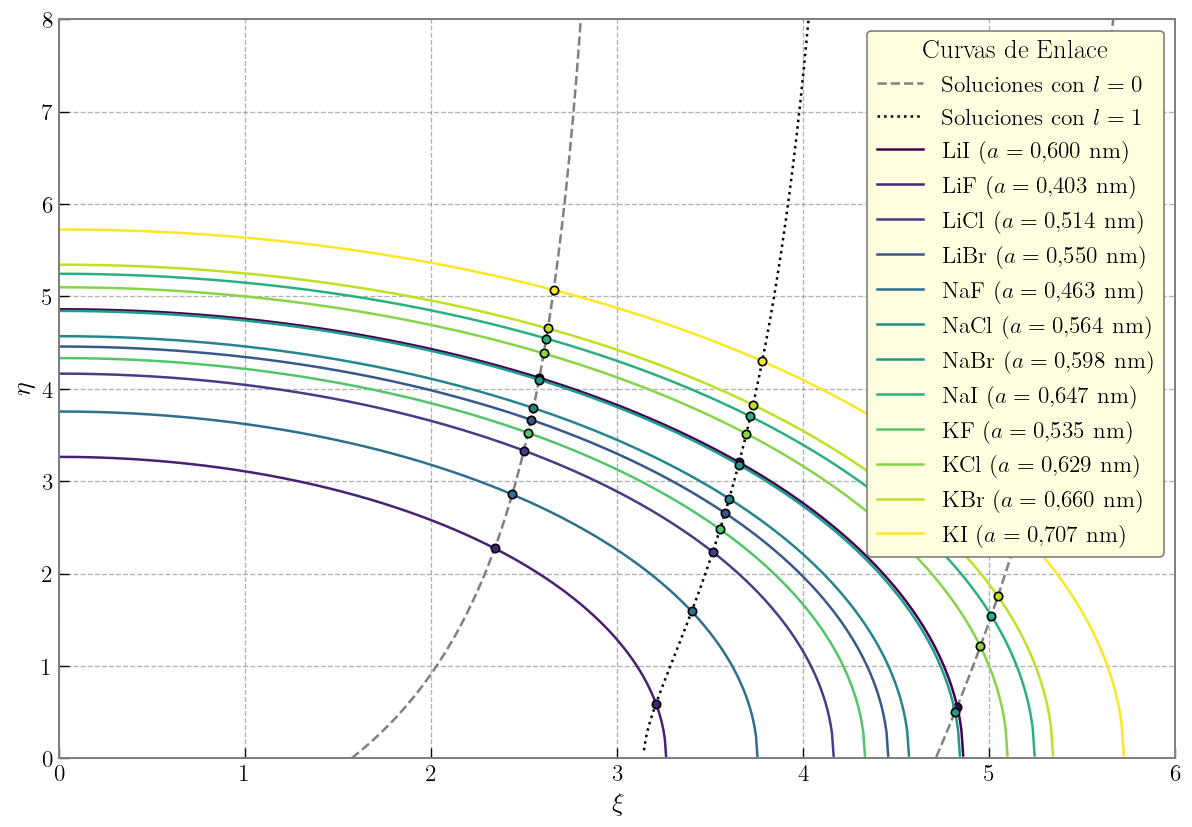

In [147]:
plot_all_crystal_bound_states(all_crystals, v0=10)

In [182]:
def get_v0_from_transition_energy(e: float, a: float) -> float:
    '''
    Get the finite spherical well potential V0 from the first transition energy

    @param e: Transition energy in eV
    @param r: Radius of the well in nm

    @return: The well depth V0 in eV
    '''
    r = sphere_radius(a,'circunscrita')*1e-9
    # Minimize the difference between the experimental observation and the model prediction
    # to get the per-cyanine V0
    def fn(v0: float) -> float:
        model_e = get_fsw_1st_transition_energy(v0, a)
        # If there is no solution, return a large value, since minimize_scalar cannot handle NaNs
        if np.isnan(model_e):
            return np.inf
        return np.abs(model_e - e)

    res = opt.minimize_scalar(fn, bounds=(1, 20), method='bounded')
    print(res)

    return res.x


def get_v0_for_crystal(crystal: str) -> float:
    return get_v0_from_transition_energy(all_crystals.loc[crystal, 'E [eV]'], all_crystals.loc[crystal, 'a [nm]'])


def plot_deltae_for_crystal(crystal: str, v0_min: float = 3, v0_max: float = 16, v0_step: float = 0.5, save: str | None = None):
    '''
    Plot the energy difference between the measurement/literature and the fsw model prediction for a given crystal.

    @param crystal: The crystal to plot.
    @param v0_min: Minimum V0 value to plot.
    @param v0_max: Maximum V0 value to plot.
    @param v0_step: Step size for V0 values.
    @param save: If specified, save the plot to this file.
    '''
    if crystal not in all_crystals.index:
        raise ValueError(f'Crystal {crystal} not found in references.')
    a = all_crystals.loc[crystal, 'a [nm]']
    r = sphere_radius(all_crystals.loc[crystal, 'a [nm]'] , 'circunscrita')*1e-9
    e_exp = all_crystals.loc[crystal, 'E [eV]']

    v0_values = np.arange(v0_min, v0_max, v0_step)
    deltae_values = [(get_fsw_1st_transition_energy(v0, a) - e_exp)**2 for v0 in v0_values]

    plt.plot(v0_values, deltae_values, label = crystal)
    plt.xlabel(r'$V_0$ [eV]')
    plt.ylabel(r'$(E_{exp} - E_{FSW})^2$ [eV]')
    plt.ylim(0, np.nanmax(deltae_values)*1.1)
    plt.legend()
    if save:
        plt.savefig(save)

C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 6.658749995835933e-08
       x: 17.043246954728517
     nit: 22
    nfev: 22


C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
c:\Users\Manuel Luaces\anaconda3\envs\fisica\Lib\site-packages\scipy\optimize\_optimize.py:2291: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
c:\Users\Manuel Luaces\anaconda3\envs\fisica\Lib\site-packages\scipy\optimize\_optimize.py:2292: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)


 message: Solution found.
 success: True
  status: 0
     fun: 2.5060783759300875e-07
       x: 12.162752982957768
     nit: 22
    nfev: 22


C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 3.867205617957836e-07
       x: 8.173628853312758
     nit: 22
    nfev: 22


C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 2.140212709278444e-07
       x: 6.730056556773998
     nit: 24
    nfev: 24


C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 4.151988974854248e-08
       x: 8.572080007007983
     nit: 22
    nfev: 22


C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 1.2414432548624177e-07
       x: 6.691653846613085
     nit: 23
    nfev: 23


C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 2.6862043656095125e-07
       x: 5.706603277663353
     nit: 26
    nfev: 26


C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 2.3256851600095274e-07
       x: 5.213379712283875
     nit: 23
    nfev: 23


C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 1.3795790287929321e-07
       x: 6.849820761837704
     nit: 22
    nfev: 22


C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 1.2503559165821798e-07
       x: 7.692640613819008
     nit: 23
    nfev: 23


C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 2.0009849244218003e-07
       x: 5.113241035284432
     nit: 19
    nfev: 19


C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 1.561848848030678e-07
       x: 4.916889934205659
     nit: 21
    nfev: 21


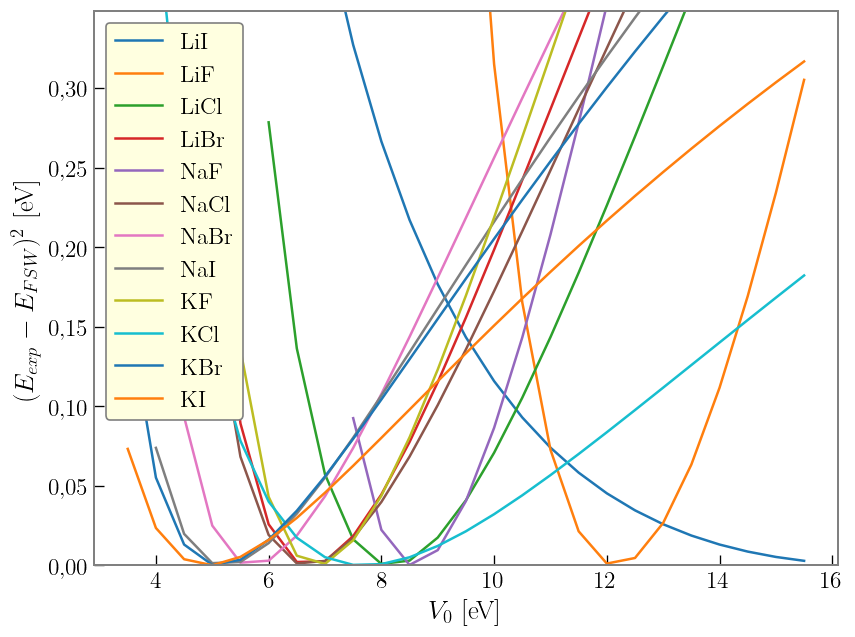

In [183]:
#Esto tarda alrededor de 20 min... pongan la pava
for crystal in all_crystals.index:
    plot_deltae_for_crystal(crystal)
    all_crystals.loc[crystal, 'V0 FSW [eV]'] = get_v0_for_crystal(crystal)
    

In [184]:
all_crystals

,a [nm],a inc. [nm],E Literatura [eV],E Medida [eV],E Medida inc. [eV],E [eV],E inc. [eV],R0 [Å],rho [Å],rho / R0,V0 Madelung [eV],V0 FSW [eV]
Sample,,,,,,,,,,,,
LiI,0.6000,0.0001,3.176,NaN,NaN,3.176000,0.003176,3.000,0.366,0.122000,7.549273,17.043247
LiF,0.4028,0.0001,5.083,NaN,NaN,5.083000,0.005083,2.014,0.291,0.144489,11.245194,12.162753
LiCl,0.5140,0.0001,3.256,NaN,NaN,3.256000,0.003256,2.570,0.330,0.128405,8.812381,8.173629
LiBr,0.5502,0.0001,2.767,NaN,NaN,2.767000,0.002767,2.751,0.340,0.123591,8.232577,6.730057
NaF,0.4634,0.0001,3.702,NaN,NaN,3.702000,0.003702,2.317,0.290,0.125162,9.774631,8.572080
NaCl,0.5640,0.0001,2.746,2.687076,0.001597,2.687076,0.001597,2.820,0.321,0.113830,8.031142,6.691654
NaBr,0.5978,0.0001,2.345,NaN,NaN,2.345000,0.002345,2.989,0.328,0.109736,7.577056,5.706603
NaI,0.6474,0.0001,2.063,NaN,NaN,2.063000,0.002063,NaN,NaN,NaN,6.996546,5.213380
KF,0.5348,0.0001,2.873,NaN,NaN,2.873000,0.002873,2.674,0.298,0.111444,8.469641,6.849821


12
12


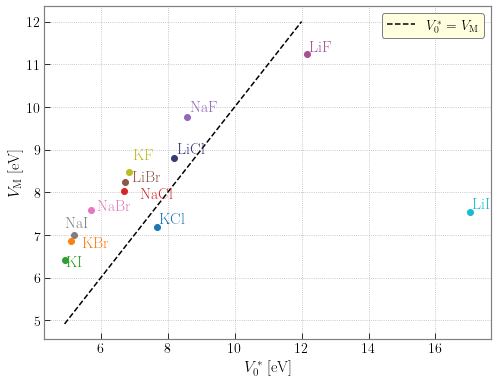

In [209]:
def get_v0_madelung(a: float) -> float:
    '''
    Estimate the well potential with the Madelung model.

    @param a: Lattice constant in nm
    @return: Estimated well potential in eV
    '''
    alpha_madelung_fcc = 1.74756
    q = 1 # Elementary ionic charge in e
    epsilon_0 = 55.26349406 * 1e-3 # e^2 / (eV * nm)
    r = a / 2 # Nearest neighbor distance
    rho = 0.1 * r # Repulsive range parameter

    return alpha_madelung_fcc * q**2 / (4 * np.pi * epsilon_0 * r) * (1 - rho / r)

all_crystals['V0 Madelung [eV]'] = get_v0_madelung(all_crystals['a [nm]'])

fig, ax = plt.subplots() 

#ax.plot(all_crystals['V0 FSW [eV]'], all_crystals['V0 Madelung [eV]'], marker='o', linestyle='None', markerfacecolor='white',color='black')
ax.set_xlabel(r'$V_0^*$ [eV]')
ax.set_ylabel(r'$V_\mathrm{M}$ [eV]')

x_values = np.linspace(all_crystals['V0 FSW [eV]'].min(), 12, 2)
ax.plot(x_values, x_values, '--', color='black', label=r'$V_0^*=V_\mathrm{M}$', lw=1.5)
x = all_crystals['V0 FSW [eV]']
y = all_crystals['V0 Madelung [eV]']
# Colores según colormap, necesito tantos colores como cristales
colors = [
     "#17becf", "#a55194", "#393b79", "#8c564b", "#9467bd","#d62728",
    "#e377c2", "#7f7f7f", "#bcbd22","#1f77b4", "#ff7f0e", "#2ca02c"
]
# Graficar datos experimentales
labels = []

print(len(all_crystals.index))
print(len(colors))


for xi, yi, ci, idx in zip(x, y, colors, all_crystals.index):
	ax.plot(xi, yi,
					marker='o', linestyle='None',
					markerfacecolor=ci, markeredgecolor=ci, zorder=200)
	labels.append(ax.text(xi, yi, idx, color=ci, horizontalalignment='left', fontsize=16, zorder=1000))
'''
labels = []
for crystal in all_crystals.index:
    labels.append(ax.text(all_crystals.loc[crystal, 'V0 FSW [eV]'], all_crystals.loc[crystal, 'V0 Madelung [eV]'], crystal, horizontalalignment='left', fontsize=14, zorder=100))
'''
adjust_text(labels, expand=(1.15, 1.15)) 
ax.legend()
ax.grid()
ax.tick_params(axis='both', which='major')
plt.savefig('v0_fsw_vs_v0_madelung.pdf' )
plt.show() 

In [210]:
Madelung_solutions = {}
FSW_solutions = {}
for crystal in all_crystals.index:
    FSW_solutions[all_crystals.loc[crystal, 'a [nm]']] = get_fsw_1st_transition_energy(all_crystals.loc[crystal, 'V0 FSW [eV]'], all_crystals.loc[crystal, 'a [nm]'])
    Madelung_solutions[all_crystals.loc[crystal, 'a [nm]']] = get_fsw_1st_transition_energy(all_crystals.loc[crystal, 'V0 Madelung [eV]'], all_crystals.loc[crystal, 'a [nm]'])

finite_solutions = {
    r'$\Delta E_\mathrm{PEF}$ con $V_0=V_0^*$' : FSW_solutions,
    r'$\Delta E_\mathrm{PEF}$ con $V_0=V_{\mathrm{M}}$': Madelung_solutions
}

C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
C:\Users\Manuel Luaces\AppData\Local\Temp\ipykernel_6160\925934915.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


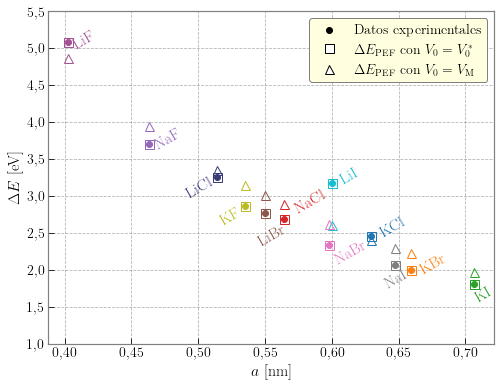

In [211]:
import matplotlib.cm as cm


def plot_all(solutions: dict[str, Callable[[float], float] | dict[float, float]] | None = None,
             legend_outside: bool = False,
             y_range: tuple[float, float] | None = None,
             save: str | None = None):

    x = all_crystals['a [nm]'].to_numpy()
    y = all_crystals['E [eV]'].to_numpy()
    yerr = all_crystals['E inc. [eV]'].to_numpy()

    # Graficar datos experimentales
    labels = []
    for xi, yi, yerri, ci, idx in zip(x, y, yerr, colors, all_crystals.index):
        plt.errorbar(xi, yi, yerr=yerri,
                     marker='o', linestyle='None',
                     markerfacecolor=ci, markeredgecolor=ci,
                     ecolor=ci, capsize=3, zorder=200)
        labels.append(plt.text(xi, yi, idx, color=ci, fontsize=16, verticalalignment ='top',horizontalalignment='center',rotation=30, zorder=1000))



    plt.scatter([], [], c='black', marker='o', edgecolor='black', label='Datos experimentales')

    # Graficar soluciones
    x_values = np.linspace(x.min(), x.max(), 1000)
    if solutions is not None:
        # Elegimos markers distintos para cada solución
        sol_markers = ['s', '^']
        for (name, sol), marker in zip(solutions.items(), sol_markers):
            xs = np.array(list(sol.keys()))
            ys = np.array(list(sol.values()))

            # Si son valores con incertidumbre
            if isinstance(ys[0], uncertainties.UFloat):
                ys_err = [v.std_dev for v in ys]
                ys = [v.n for v in ys]
                for xi, yi, yei, ci in zip(xs, ys, ys_err, colors):
                    plt.errorbar(xi, yi, yerr=yei, marker=marker, linestyle='None',
                                 markerfacecolor='none', markeredgecolor=ci,
                                 ecolor=ci, capsize=3, label=name)
            else:
                for xi, yi, ci in zip(xs, ys, colors):
                    plt.plot(xi, yi, marker=marker, linestyle='None',
                             markerfacecolor='none', markeredgecolor=ci, markersize=9)
                    plt.text(xi, yi, '', color=ci)  # opcional si no querés texto adicional
            plt.plot([], [], marker=marker, markersize=9, color='white',markeredgecolor='black', linestyle='None', label=name)  # para la leyenda

    plt.xlabel(r'$a$ [nm]')
    plt.ylabel(r'$\Delta E$ [eV]')
    plt.tick_params(axis='both', which='major')
    plt.grid(True, linestyle='--')
    if y_range is not None:
        plt.ylim(y_range)

    adjust_text(labels, expand=(1.16, 1.16))

    if legend_outside:
        plt.legend( loc='upper left')
    else:
        plt.legend()

    if save:
        plt.savefig(save)




plot_all(finite_solutions, y_range=(1,5.5), save='pozo finito resultados.pdf')


In [188]:
# Calcular el valor del chi-cuadradrado para cada modelo: pozo cúbico infinito, pozo esférico infinito, pozo esférico finito con V0 y pozo esférico finito con V_M
def calculate_reduced_chi_squared(model_solutions: dict[float, float], all_crystals: pd.DataFrame) -> float:
	chi_squared = 0.0
	for crystal in all_crystals.index:
		a = all_crystals.loc[crystal, 'a [nm]']
		e_exp = all_crystals.loc[crystal, 'E [eV]']
		e_inc = all_crystals.loc[crystal, 'E inc. [eV]']

		if a in model_solutions:
			e_model = model_solutions[a]
			chi_squared += ((e_exp - e_model) ** 2) / (e_inc ** 2)
	# Reduced chi-squared: divide by degrees of freedom (N - p), where N is number of data points and p is number of parameters (1 for these models)
	ndof = len(all_crystals) - 1
	chi_squared 
	return chi_squared
chi_squared_results = {
	'Pozo cúbico infinito': {a: pozo_cubico_inf(a) for a in all_crystals['a [nm]']},
	'Pozo esférico infinito (R=a/2)': {a: pozo_esferico_inf(sphere_radius(a, 'circunscrita')) for a in all_crystals['a [nm]']},
	'Pozo esférico infinito (R=a/√2)': {a: pozo_esferico_inf(sphere_radius(a, 'inscrita')) for a in all_crystals['a [nm]']},
	'Pozo esférico infinito (V_esf=V_oct)': {a: pozo_esferico_inf(sphere_radius(a, 'volumen')) for a in all_crystals['a [nm]']},
	'Pozo esférico finito con V0': FSW_solutions,
	'Pozo esférico finito con V_M': Madelung_solutions
}
for model_name, solutions in chi_squared_results.items():
	chi2 = calculate_reduced_chi_squared(solutions, all_crystals)
	print(f'Chi-cuadrado reducido para {model_name}: {chi2:.2f}')
 
 #armar una tabla con los chi-cuadrado reducido de cada modelo
chi_squared_table = pd.DataFrame(columns=['Modelo', 'Chi-cuadrado reducido'])
for model_name, solutions in chi_squared_results.items():
	chi2 = calculate_reduced_chi_squared(solutions, all_crystals)
	chi_squared_table['Modelo'] = chi_squared_results.keys()
	chi_squared_table['Chi-cuadrado reducido'] = [calculate_reduced_chi_squared(solutions, all_crystals) for solutions in chi_squared_results.values()]
chi_squared_table


Chi-cuadrado reducido para Pozo cúbico infinito: 12189303.20
Chi-cuadrado reducido para Pozo esférico infinito (R=a/2): 97468018.78
Chi-cuadrado reducido para Pozo esférico infinito (R=a/√2): 4560893.06
Chi-cuadrado reducido para Pozo esférico infinito (V_esf=V_oct): 1376933385.44
Chi-cuadrado reducido para Pozo esférico finito con V0: 0.00
Chi-cuadrado reducido para Pozo esférico finito con V_M: 1527954.52


,Modelo,Chi-cuadrado reducido
0,Pozo cúbico infinito,1.218930e+07
1,Pozo esférico infinito (R=a/2),9.746802e+07
2,Pozo esférico infinito (R=a/√2),4.560893e+06
3,Pozo esférico infinito (V_esf=V_oct),1.376933e+09
4,Pozo esférico finito con V0,1.362798e-06
5,Pozo esférico finito con V_M,1.527955e+06


In [189]:
# Datos extraídos de la columna "Nearest-Neighbor Separation R0, in Å"
# (La columna 1 de la tabla)
nearest_neighbor_separation_R0 = [
    3.000,   # LiI
    2.014,   # LiF
    2.570,   # LiCl
    2.751,   # LiBr
    2.317,   # NaF
    2.820,   # NaCl
    2.989,   # NaBr
    np.nan,    # NaI (No aparece en la tabla)
    2.674,   # KF
    3.147,   # KCl
    3.298,   # KBr
    3.533    # KI
]

# Datos extraídos de la columna "Repulsive Range Parameter rho, in Å"
# (La columna 4 de la tabla)
repulsive_range_parameter_rho = [
    0.366,   # LiI
    0.291,   # LiF
    0.330,   # LiCl
    0.340,   # LiBr
    0.290,   # NaF
    0.321,   # NaCl
    0.328,   # NaBr
    np.nan,    # NaI (No aparece en la tabla)
    0.298,   # KF
    0.326,   # KCl
    0.336,   # KBr
    0.348    # KI
]

for crystal, r0, rho in zip(all_crystals.index, nearest_neighbor_separation_R0, repulsive_range_parameter_rho):
	all_crystals.loc[crystal, 'R0 [Å]'] = r0
	all_crystals.loc[crystal, 'rho [Å]'] = rho
	all_crystals.loc[crystal, 'rho / R0'] = np.array(rho) / np.array(r0)
 
all_crystals

,a [nm],a inc. [nm],E Literatura [eV],E Medida [eV],E Medida inc. [eV],E [eV],E inc. [eV],R0 [Å],rho [Å],rho / R0,V0 Madelung [eV],V0 FSW [eV]
Sample,,,,,,,,,,,,
LiI,0.6000,0.0001,3.176,NaN,NaN,3.176000,0.003176,3.000,0.366,0.122000,7.549273,17.043247
LiF,0.4028,0.0001,5.083,NaN,NaN,5.083000,0.005083,2.014,0.291,0.144489,11.245194,12.162753
LiCl,0.5140,0.0001,3.256,NaN,NaN,3.256000,0.003256,2.570,0.330,0.128405,8.812381,8.173629
LiBr,0.5502,0.0001,2.767,NaN,NaN,2.767000,0.002767,2.751,0.340,0.123591,8.232577,6.730057
NaF,0.4634,0.0001,3.702,NaN,NaN,3.702000,0.003702,2.317,0.290,0.125162,9.774631,8.572080
NaCl,0.5640,0.0001,2.746,2.687076,0.001597,2.687076,0.001597,2.820,0.321,0.113830,8.031142,6.691654
NaBr,0.5978,0.0001,2.345,NaN,NaN,2.345000,0.002345,2.989,0.328,0.109736,7.577056,5.706603
NaI,0.6474,0.0001,2.063,NaN,NaN,2.063000,0.002063,NaN,NaN,NaN,6.996546,5.213380
KF,0.5348,0.0001,2.873,NaN,NaN,2.873000,0.002873,2.674,0.298,0.111444,8.469641,6.849821


In [212]:
# calcular el V0_Madelung usando R0 y rho de la tabla para el LiF y el LiI y comparar con el V0_Madelung calculado previamente
for crystal in ['LiF', 'LiI']:
	r0 = all_crystals.loc[crystal, 'R0 [Å]'] * 1e-1 # convertir a nm
	rho = all_crystals.loc[crystal, 'rho [Å]'] * 1e-1 # convertir a nm
	a = all_crystals.loc[crystal, 'a [nm]']
	q = 1 # Elementary ionic charge in e
	epsilon_0 = 55.26349406 * 1e-3 # e^2 / (eV * nm)
	alpha_madelung_fcc = 1.74756
	v0_madelung_table = alpha_madelung_fcc * q**2 / (4 * np.pi * epsilon_0 * r0) * (1 - rho / r0)
	print(f'V0_Madelung para {crystal} usando R0 y rho de la tabla: {v0_madelung_table:.2f} eV')
	print(f'V0_Madelung para {crystal} calculado previamente: {all_crystals.loc[crystal, "V0 Madelung [eV]"]:.2f} eV')
 


V0_Madelung para LiF usando R0 y rho de la tabla: 10.69 eV
V0_Madelung para LiF calculado previamente: 11.25 eV
V0_Madelung para LiI usando R0 y rho de la tabla: 7.36 eV
V0_Madelung para LiI calculado previamente: 7.55 eV
